In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
%matplotlib inline

In [2]:
BASIC_PATH = os.getcwd()+'/highD-dataset'
recording_ids = [str(idx) if not len(str(idx)) == 1 else '0' + str(idx) for idx in list(range(1,61))]
data_prefix = BASIC_PATH+'/data/'
image_suffix = '_highway.jpg'
recording_meta_suffix = '_recordingMeta.csv'
tracks_meta_suffix = '_tracksMeta.csv'
tracks_suffix = '_tracks.csv'

In [3]:
track_meta_01 = pd.read_csv(data_prefix + recording_ids[0] + tracks_meta_suffix).set_index('id')
filtered_track_meta_01 = track_meta_01[(track_meta_01['numFrames'] >= 100) & (track_meta_01['minDHW'] > 0) & (track_meta_01['minTHW'] > 0) & (track_meta_01['minTTC'] > 0) & (track_meta_01['numLaneChanges'] > 0)]
filtered_track_meta_01.head()
df = filtered_track_meta_01
df['label'] = 1
df = df.drop('initialFrame',axis =1)
df = df.drop('finalFrame',axis =1)
df = df.drop('numFrames',axis =1)
df = df[df.drivingDirection == 1]
df = df.drop('drivingDirection',axis =1)
#df = df[df['class']==1]
df = df.drop('class', axis=1)
df = df.drop('traveledDistance', axis=1)
df = df.drop('width', axis=1)
df = df.drop('height', axis=1)
df = df.reset_index()

/home/manu/anaconda3/envs/commonroad-py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [4]:
limits = {}
for c in df.columns:
    limits[c] = (df[c].min(), df[c].max())

In [5]:
i = limits['id'][1]
ind = 100
lab = 2
limits.pop('id')
limits.pop('label')
limits.pop('numLaneChanges')

(1, 2)

In [6]:
for j in range(ind, ind + 100):
    dat = [i]
    i += 1
    for it in limits.values():
        dat.append(np.random.uniform(it[0], it[1]))
    dat.append(np.random.randint(1,3))
    dat.append(2)
    df = pd.concat([df, pd.DataFrame(data = np.array([dat]), index = [j], columns = df.columns)])

In [7]:
df

,id,minXVelocity,maxXVelocity,meanXVelocity,minDHW,minTHW,minTTC,numLaneChanges,label
0,9.0,35.990000,36.620000,36.420000,33.680000,0.920000,9.740000,1.0,1.0
1,30.0,30.820000,31.730000,31.440000,42.130000,1.330000,6.800000,1.0,1.0
2,58.0,32.640000,35.390000,34.500000,33.550000,0.950000,2.610000,1.0,1.0
3,79.0,24.660000,34.410000,30.010000,7.180000,0.230000,3.380000,1.0,1.0
4,96.0,36.720000,37.650000,37.260000,39.800000,1.070000,4.910000,1.0,1.0
...,...,...,...,...,...,...,...,...,...
195,1126.0,31.260903,34.990649,33.587806,258.672107,3.338179,665.123547,1.0,2.0
196,1127.0,30.968264,31.317675,37.275677,363.770490,9.534382,376.798471,2.0,2.0
197,1128.0,28.392369,42.642619,26.202939,266.759059,8.149797,1285.492238,1.0,2.0
198,1129.0,31.212264,32.693214,41.758202,42.058254,9.130846,1358.401163,2.0,2.0


In [8]:
rfc = RandomForestClassifier(n_estimators = 300)

In [9]:
X = df.drop('label', axis = 1)

In [10]:
y = df['label']

In [11]:
rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [12]:
def proximityMatrix(model, X, normalize=True):      

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    if normalize:
        proxMat = proxMat / nTrees

    return proxMat

In [13]:
distMatrix = 1 - proximityMatrix(rfc, X, normalize=True)

In [14]:
distDf = pd.DataFrame(data = distMatrix, columns = range(159), index = range(159))

In [15]:
cropped = distDf[distDf.index < 59].drop(range(59,159), axis = 1)

In [16]:
cluster = AgglomerativeClustering(affinity='precomputed', linkage = 'complete', n_clusters = 6)

In [17]:
res = cluster.fit_predict(cropped)

/home/manu/anaconda3/envs/commonroad-py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


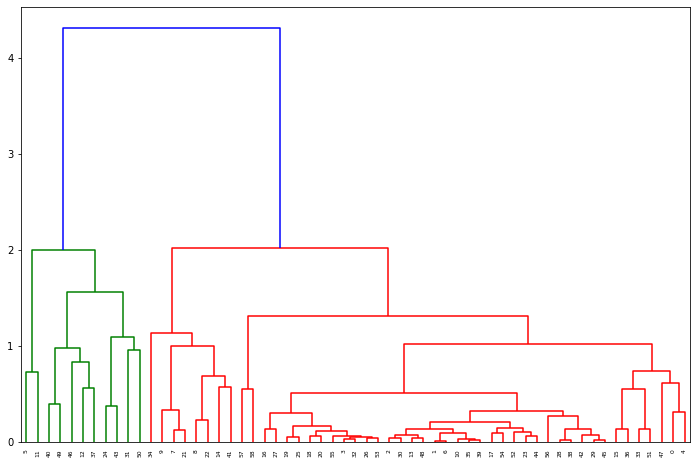

In [31]:
fix, ax = plt.subplots(figsize = (12,8))

sch.dendrogram(sch.linkage(cropped, method = 'complete'), ax = ax)
plt.savefig('dendro.png')
plt.show()

In [19]:
ff = df[df['label'] < 2]

In [20]:
ff['cluster'] = res

/home/manu/anaconda3/envs/commonroad-py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
ff

,id,minXVelocity,maxXVelocity,meanXVelocity,minDHW,minTHW,minTTC,numLaneChanges,label,cluster
0,9.0,35.99,36.62,36.42,33.68,0.92,9.74,1.0,1.0,2
1,30.0,30.82,31.73,31.44,42.13,1.33,6.80,1.0,1.0,5
2,58.0,32.64,35.39,34.50,33.55,0.95,2.61,1.0,1.0,5
3,79.0,24.66,34.41,30.01,7.18,0.23,3.38,1.0,1.0,5
4,96.0,36.72,37.65,37.26,39.80,1.07,4.91,1.0,1.0,2
5,116.0,37.04,37.73,37.32,367.93,9.77,91.46,1.0,1.0,4
6,119.0,30.35,30.50,30.43,30.41,0.99,7.03,1.0,1.0,5
7,123.0,41.02,42.58,41.32,41.48,1.01,3.39,2.0,1.0,2
8,126.0,39.00,42.75,40.35,80.82,2.00,9.96,1.0,1.0,2
9,139.0,37.52,38.29,37.93,34.89,0.91,3.79,2.0,1.0,2


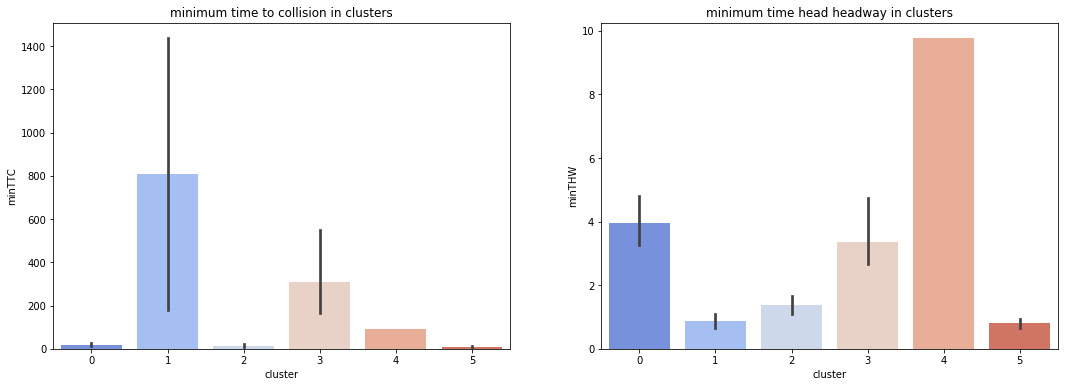

In [22]:
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (18, 6))

sns.barplot(x="cluster", y="minTTC", data=ff, palette="coolwarm", ax = ax[0])
sns.barplot(x="cluster", y="minTHW", data=ff, palette="coolwarm", ax = ax[1])

ax[0].set_title('minimum time to collision in clusters')
ax[1].set_title('minimum time head headway in clusters')

plt.savefig('clusters.png')

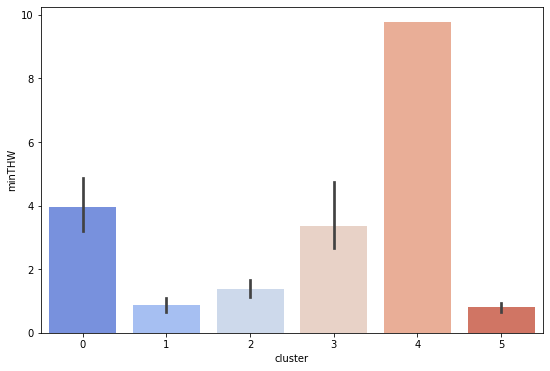

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (9, 6))

ax = sns.barplot(x="cluster", y="minTHW", data=ff, palette="coolwarm")


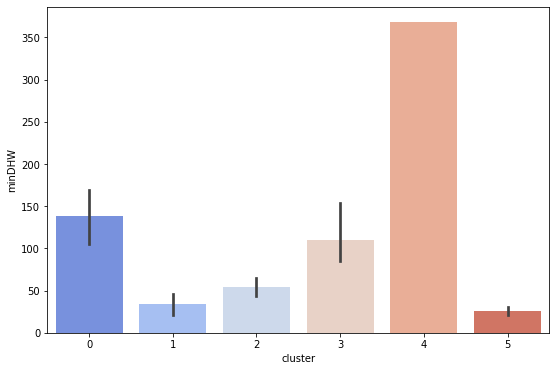

In [24]:
fig, ax = plt.subplots(1, 1, figsize = (9, 6))

ax = sns.barplot(x="cluster", y="minDHW", data=ff, palette="coolwarm")

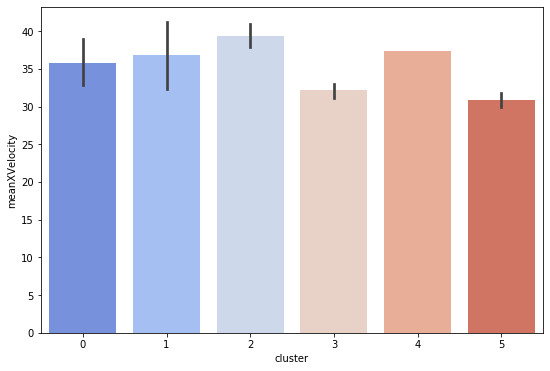

In [25]:
fig, ax = plt.subplots(1, 1, figsize = (9, 6))

ax = sns.barplot(x="cluster", y="meanXVelocity", data=ff, palette="coolwarm")

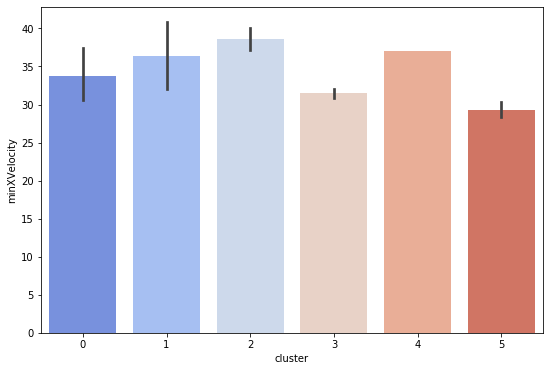

In [26]:
fig, ax = plt.subplots(1, 1, figsize = (9, 6))

ax = sns.barplot(x="cluster", y="minXVelocity", data=ff, palette="coolwarm")

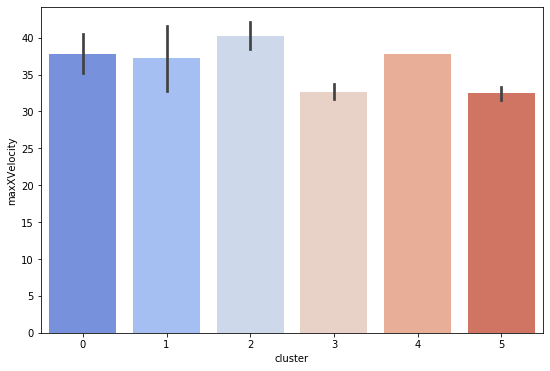

In [27]:
fig, ax = plt.subplots(1, 1, figsize = (9, 6))

ax = sns.barplot(x="cluster", y="maxXVelocity", data=ff, palette="coolwarm")

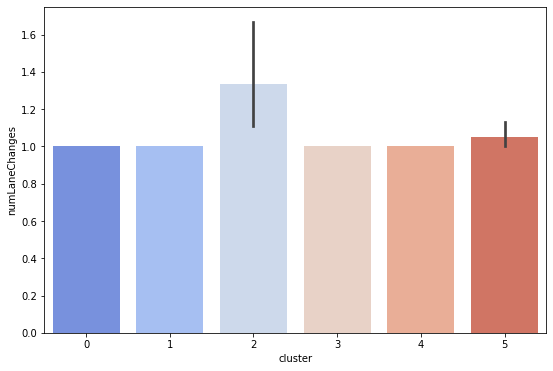

In [28]:
fig, ax = plt.subplots(1, 1, figsize = (9, 6))

ax = sns.barplot(x="cluster", y="numLaneChanges", data=ff, palette="coolwarm")

/home/manu/anaconda3/envs/commonroad-py37/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


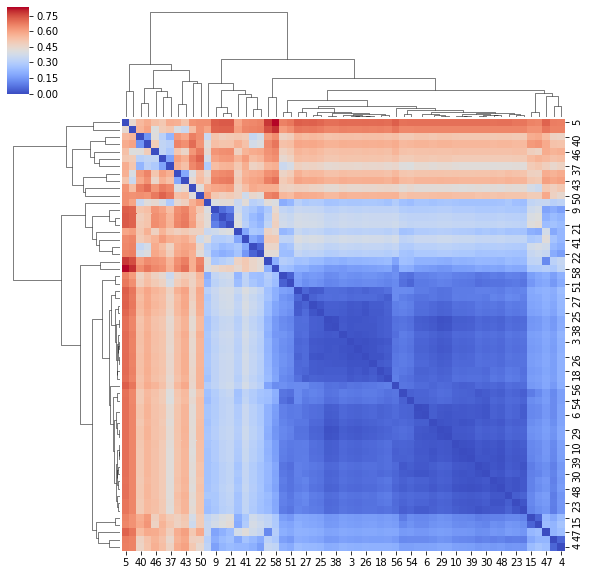

In [29]:
sns.clustermap(cropped, cmap = 'coolwarm')

plt.savefig('map.png')

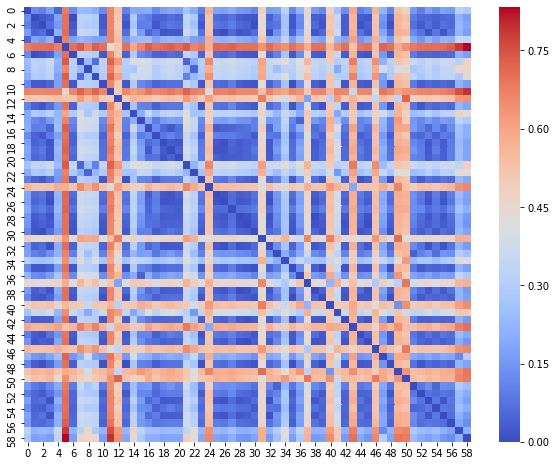

In [30]:
fig, ax = plt.subplots(figsize = (10,8))

sns.heatmap(cropped, cmap = 'coolwarm', ax = ax)

